To reveal coordination or co-regulation patterns between genes by constructing a similarity network based on how similarly their expression-accessibility agreement patterns evolve across time.

/var/folders/29/w54hnxjs18q9cvq1pfzwym540000gn/T/ipykernel_20287/2334886998.py:71: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


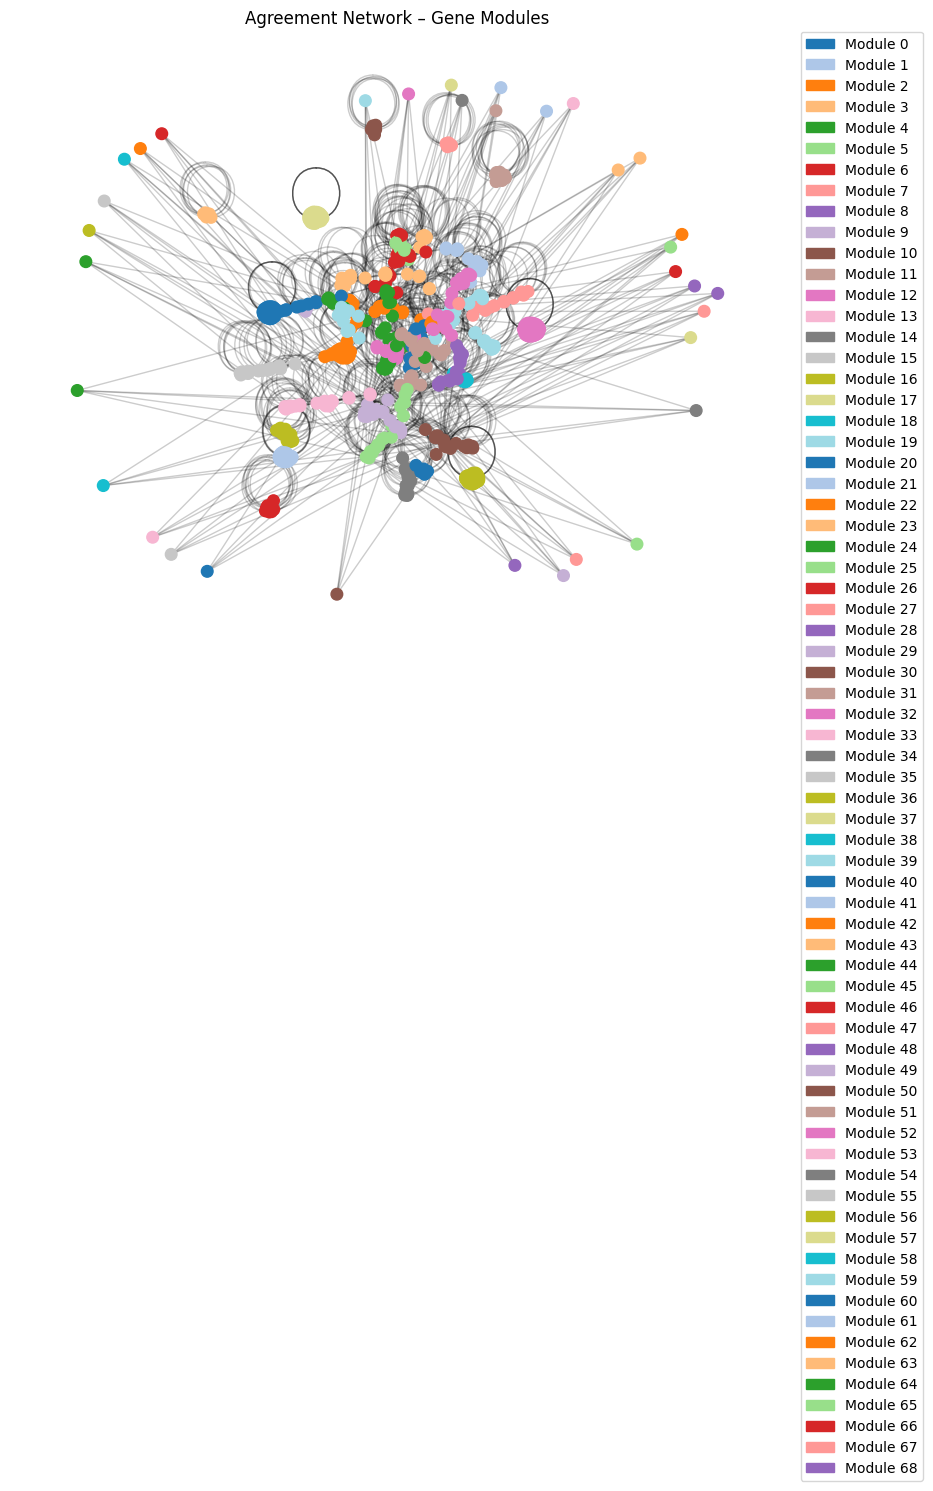

In [6]:
import pandas as pd
import numpy as np
import ast
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Load
df = pd.read_csv("data/green_monkey/all_structure_files/chr1/chr1_feature_agreement_summary.csv")
if "gene_name" in df.columns:
    df = df.set_index("gene_name")

# Parse agreement vectors (in case they are stored as strings)
def parse_agreement(val):
    if isinstance(val, str):
        return ast.literal_eval(val)
    return val

df["agreement_vec"] = df["expr_acc_tss_agreement"].apply(parse_agreement)

# Encode agreement labels as integers for similarity (make mapping explicit)
labels = sorted({a for vec in df["agreement_vec"] for a in vec})
label2int = {label: i for i, label in enumerate(labels)}
df["vec_encoded"] = df["agreement_vec"].apply(lambda v: [label2int[x] for x in v])

# Create similarity matrix (cosine over encoded vectors)
A = np.stack(df["vec_encoded"].values)
sim = cosine_similarity(A)

# Build top-k NN graph (e.g., k=5)
k = 5
genes = df.index.tolist()
G = nx.Graph()
for i, gene in enumerate(genes):
    top_k_idx = np.argsort(sim[i])[::-1][1:k+1]  # skip self
    for j in top_k_idx:
        G.add_edge(gene, genes[j], weight=sim[i, j])

# Community detection (Louvain)
partition = community_louvain.best_partition(G)
nx.set_node_attributes(G, partition, "module")

# Visualize network (color by module) with legend
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)
modules = sorted(set(partition.values()))
mod_color_map = {mod: plt.cm.tab20(mod % 20) for mod in modules}
node_colors = [mod_color_map[partition[gene]] for gene in G.nodes()]

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=70)
nx.draw_networkx_edges(G, pos, alpha=0.2)

# Legend handles
patches = [mpatches.Patch(color=mod_color_map[mod], label=f"Module {mod}") for mod in modules]
plt.legend(handles=patches, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)

plt.title("Agreement Network – Gene Modules")
plt.axis("off")
plt.tight_layout()
plt.show()





Modules with at least 30 genes: [0, 1, 12, 16, 17, 19, 22, 32]


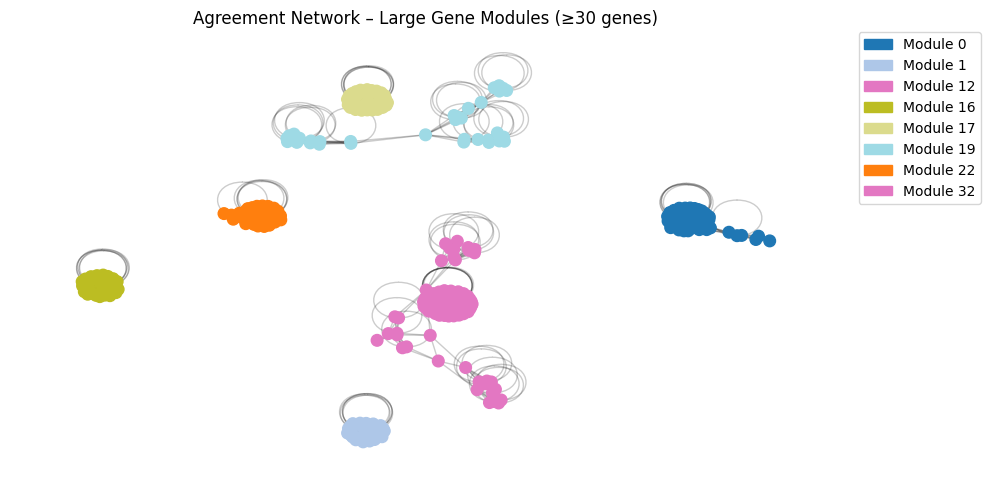

In [12]:
from collections import Counter

# Count the number of genes in each module
module_counts = Counter(partition.values())

# Filter modules with at least 10 genes
large_modules = [mod for mod, count in module_counts.items() if count >= 30]
print(f"Modules with at least 30 genes: {large_modules}")

# Get gene names for each large module
# for mod in large_modules:
#     genes_in_mod = [gene for gene, m in partition.items() if m == mod]
#     print(f"\nModule {mod} (size: {len(genes_in_mod)} genes):")
#     print(genes_in_mod)


# Subgraph containing only nodes in large modules
nodes_to_draw = [gene for gene in G.nodes() if partition[gene] in large_modules]
G_sub = G.subgraph(nodes_to_draw)

# Redefine color mapping for the subgraph
node_colors = [mod_color_map[partition[gene]] for gene in G_sub.nodes()]

plt.figure(figsize=(10, 5))
pos = nx.spring_layout(G_sub, seed=42)
nx.draw_networkx_nodes(G_sub, pos, node_color=node_colors, node_size=70)
nx.draw_networkx_edges(G_sub, pos, alpha=0.2)
# Only show legend for large modules
patches = [mpatches.Patch(color=mod_color_map[mod], label=f"Module {mod}") for mod in large_modules]
plt.legend(handles=patches, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)

plt.title("Agreement Network – Large Gene Modules (≥30 genes)")
plt.axis("off")
plt.tight_layout()
plt.show()



In [13]:
# Optional: Save module assignments
df["agreement_module"] = [partition[gene] for gene in genes]
# df.to_csv("chr1_agreement_network_with_modules.csv")
df.head()

,log2FC_12h,log2FC_18h,log2FC_24h,acc_untr_12h_tss,acc_untr_12h_avg,acc_vacv_12h_tss,acc_vacv_12h_avg,acc_untr_18h_tss,acc_untr_18h_avg,acc_vacv_18h_tss,...,expr_up_acc_down,expr_down_acc_up,agreement_class,tsne_1,tsne_2,tsne_expr_1,tsne_expr_2,agreement_vec,vec_encoded,agreement_module
gene_name,,,,,,,,,,,,,,,,,,,,,
BET1L,-0.315039,-0.368512,-0.155558,18.76570,23.817953,6.06692,16.777641,3.32283,13.126565,5.44286,...,0,0,accessibility_only,-15.009315,3.647945,-15.009315,3.647945,"[acc_only_down, acc_only_up, acc_only_up]","[0, 1, 1]",0
RIC8A,-0.295795,-0.221668,-0.362167,18.76570,19.728002,4.04461,16.552940,4.22906,15.305173,5.44286,...,0,0,accessibility_only,-19.110851,1.868840,-19.110851,1.868840,"[acc_only_down, acc_only_up, acc_only_down]","[0, 1, 0]",1
SIRT3,0.552196,-0.984313,0.300940,3.84937,15.466200,4.71871,12.673082,3.62491,9.389523,3.26571,...,0,0,expression_only,-10.827722,-10.180895,-10.827722,-10.180895,"[acc_only_up, expr_only_down, acc_only_down]","[1, 4, 0]",2
PSMD13,-0.625220,-0.688457,-0.557435,8.66107,16.039015,17.52660,15.953700,5.73944,10.908291,10.88570,...,0,2,conflict,-27.876356,5.604334,-27.876356,5.604334,"[expr_down_acc_up, expr_down_acc_up, acc_only_up]","[3, 3, 1]",3
NLRP6,0.000000,0.000000,3.404529,2.88702,3.007315,4.04461,5.055765,3.02076,3.840676,4.35428,...,1,0,accessibility_only,42.989323,12.824819,42.989323,12.824819,"[acc_only_up, acc_only_up, expr_up_acc_down]","[1, 1, 6]",4


In [15]:
from collections import Counter

# For modules of interest (e.g., large_modules from before)
module_patterns = {}

for mod in large_modules:
    genes_in_mod = [gene for gene, m in partition.items() if m == mod]
    # Collect agreement vectors for this module
    vecs = df.loc[genes_in_mod, "agreement_vec"].tolist()
    # For each timepoint, get the dominant label (mode)
    dominant_labels = []
    for t in range(len(vecs[0])):  # assuming all vectors have same length
        labels_at_t = [vec[t] for vec in vecs]
        dominant_label = Counter(labels_at_t).most_common(1)[0][0]
        dominant_labels.append(dominant_label)
    module_patterns[mod] = {
        "dominant_pattern": dominant_labels,
        "gene_count": len(genes_in_mod)
    }

# Print the dominant pattern and gene count for each module
for mod, info in module_patterns.items():
    pattern = info["dominant_pattern"]
    count = info["gene_count"]
    print(f"Module {mod}: {count} genes, Dominant pattern: {pattern}")


Module 0: 54 genes, Dominant pattern: ['acc_only_down', 'decrease', 'decrease']
Module 1: 31 genes, Dominant pattern: ['acc_only_down', 'acc_only_up', 'acc_only_down']
Module 12: 35 genes, Dominant pattern: ['neutral', 'acc_only_up', 'acc_only_up']
Module 16: 37 genes, Dominant pattern: ['acc_only_up', 'acc_only_down', 'acc_only_down']
Module 17: 41 genes, Dominant pattern: ['acc_only_down', 'acc_only_down', 'expr_up_acc_down']
Module 19: 35 genes, Dominant pattern: ['increase', 'increase', 'expr_up_acc_down']
Module 22: 37 genes, Dominant pattern: ['acc_only_up', 'acc_only_up', 'acc_only_down']
Module 32: 62 genes, Dominant pattern: ['decrease', 'decrease', 'decrease']
